In [1]:
import pandas as pd
import numpy as np
import os
import cv2

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Dense, Activation
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import backend as K

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot as plt
%matplotlib inline
ROWS = 180  #720
COLS = 320 #1280
CHANNELS = 3
SPECIES_CLASSES = ['Loxodonta']
DIRECTORY = "/Users/Luxive/OneDrive/Machine Learning/Harvard/Final Project/"

Using TensorFlow backend.


In [2]:
import sys
print(sys.version)
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)
print("OpenCV version",cv2.__version__)

3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
Pandas version: 0.19.1
Numpy version: 1.11.2
OpenCV version 3.1.0


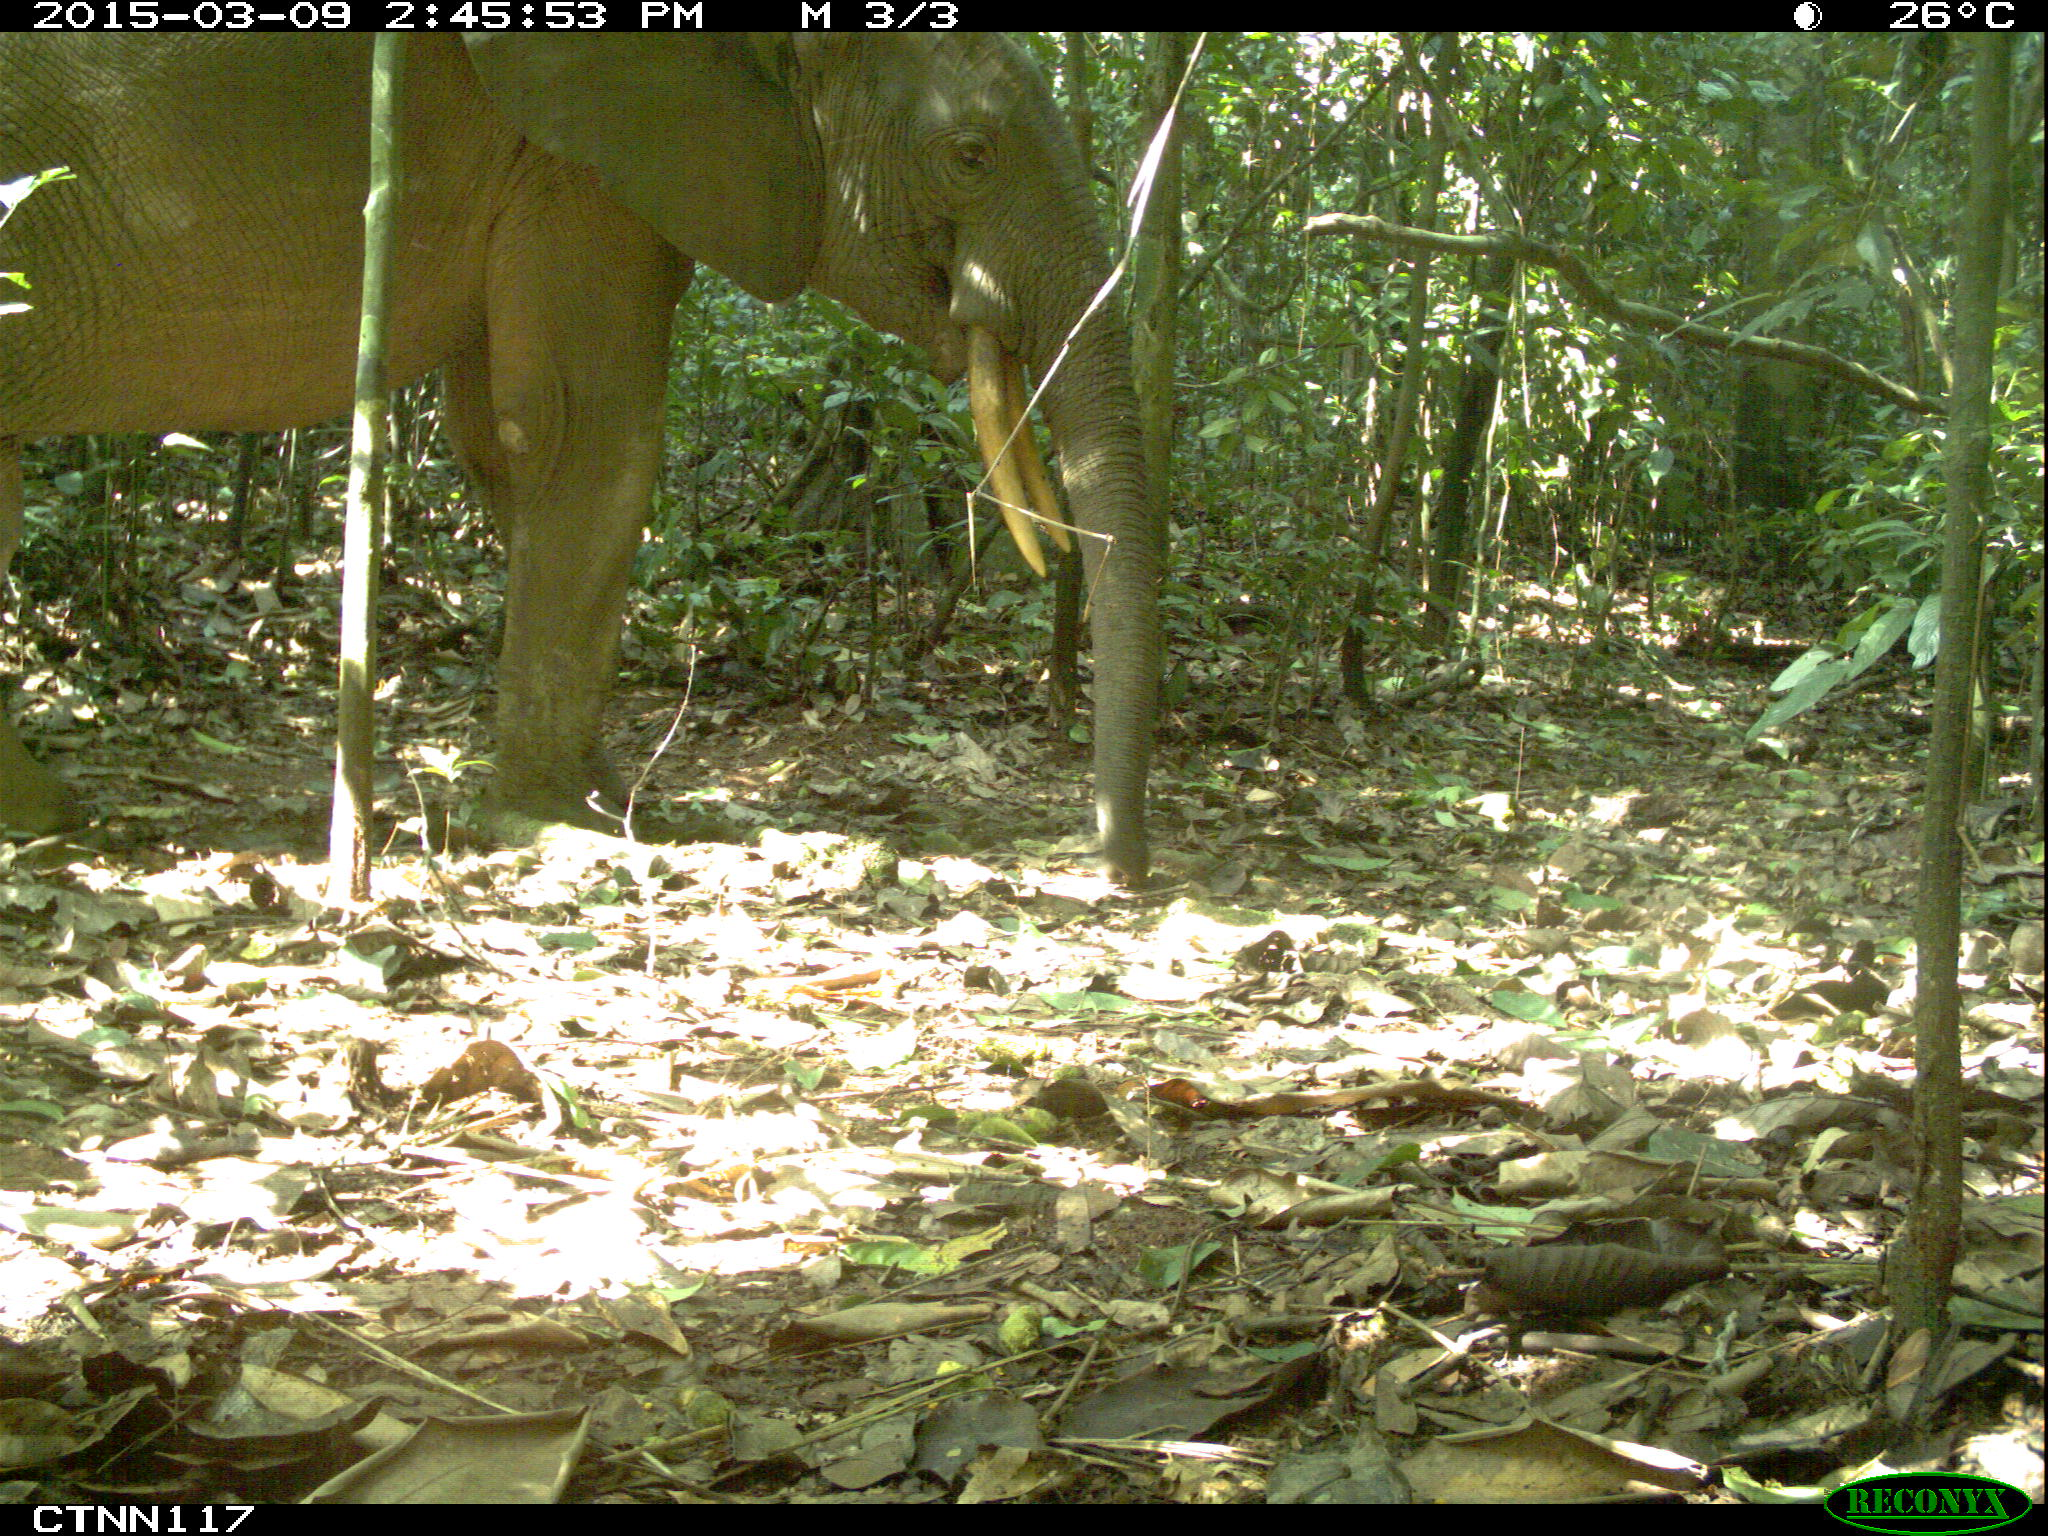

In [36]:
from IPython.display import Image
filename = "/Users/Luxive/Dropbox/TEAM_Machine Learning/Loxodonta/TEAM-DataPackage-20161115123529_3242/Terrestrial Vertebrate/NNN/2014.01/CT-NNN-1/CT-NNN-1-17/100-IMG_4191.JPG"
Image(filename) 

In [37]:
def get_images(species):
    """Load files from directory folder"""
    """Use os.walk() traversal method"""
    images = []
    for root, dirs, files in os.walk(DIRECTORY+species):
        for file in files:
            if file.endswith(".JPG"):
                images.append(file)
    return images

def read_image(src):
    """Read and resize individual images"""
    im = cv2.imread(src, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (COLS, ROWS), interpolation=cv2.INTER_CUBIC)
    return im

files = []
y_all = []

for species in SPECIES_CLASSES:
    species_files = get_images(species)
    files.extend(species_files)

    y_species = np.tile(species, len(species_files))
    y_all.extend(y_species)
    print("{0} photos of {1}".format(len(species_files), species))
    
y_all = np.array(y_all)

258 photos of Loxodonta


In [38]:
X_all = np.ndarray((len(files), ROWS, COLS, CHANNELS), dtype=np.uint8)
for i, im in enumerate(files): 
    X_all[i] = read_image(DIRECTORY+species+'/'+im)
    if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))

print(X_all.shape)

Processed 0 of 258
(258, 180, 320, 3)


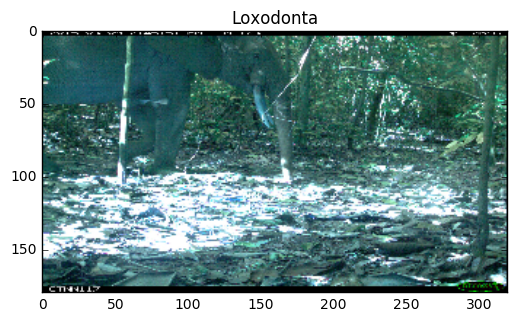

In [5]:
# check out a species from each class
uniq = np.unique(y_all, return_index=True)
for f, i in zip(uniq[0], uniq[1]):
    plt.imshow(X_all[i])
    plt.title(f)
    plt.show()

In [6]:
# One Hot Encoding Labels
y_all = LabelEncoder().fit_transform(y_all)
y_all = np_utils.to_categorical(y_all)

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, 
                                                    test_size=0.2, random_state=23, 
                                                    stratify=y_all)

In [7]:
optimizer = RMSprop(lr=1e-4)
objective = 'sparse_categorical_crossentropy'

def center_normalize(x):
    return (x - K.mean(x)) / K.std(x)

model = Sequential()

model.add(Activation(activation=center_normalize, input_shape=(ROWS, COLS, CHANNELS)))

model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(len(SPECIES_CLASSES)))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer)

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')        
        
model.fit(X_train, y_train, batch_size=64, nb_epoch=1,
              validation_split=0.2, verbose=1, shuffle=True, callbacks=[early_stopping])

Train on 164 samples, validate on 42 samples
Epoch 1/1


InvalidArgumentError: Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
	 [[Node: SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT64, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_9, Cast)]]

Caused by op 'SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits', defined at:
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-f8da62f77950>", line 38, in <module>
    model.compile(loss=objective, optimizer=optimizer)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/keras/models.py", line 578, in compile
    **kwargs)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/keras/engine/training.py", line 604, in compile
    sample_weight, mask)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/keras/engine/training.py", line 303, in weighted
    score_array = fn(y_true, y_pred)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/keras/objectives.py", line 45, in sparse_categorical_crossentropy
    return K.sparse_categorical_crossentropy(y_pred, y_true)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 1468, in sparse_categorical_crossentropy
    cast(flatten(target), 'int64'))
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 764, in sparse_softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1857, in _sparse_softmax_cross_entropy_with_logits
    features=features, labels=labels, name=name)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
	 [[Node: SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT64, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_9, Cast)]]


In [39]:
# bb_metadata = pd.read_csv("data/TV-20161130134129_5302.csv", header=46,low_memory=False)
nnn_metadata = pd.read_csv("/Users/Luxive/Dropbox/TEAM_Machine Learning/Loxodonta/TEAM-DataPackage-20161205130624_1284/Terrestrial Vertebrate/TV-20161205130624_1284.csv", header=46,low_memory=False)
# vr_metadata = pd.read_csv("data/TV-20161204185054_1706.csv", header=46,low_memory=False)
# udz_metadata = pd.read_csv("data/TV-20161204185203_1536.csv", header=46,low_memory=False)

In [45]:
df_metadata = pd.concat([bb_metadata, nnn_metadata, vr_metadata, udz_metadata])

In [40]:
nnn_metadata['Species'].count()

31485

In [41]:
# expected versus actual images
series = pd.Series({"ExpectedImages": nnn_metadata['Species'].count(), "ActualImages": i})
image_check = pd.DataFrame([series])
image_check['Difference'] = image_check['ExpectedImages'] - image_check['ActualImages']
image_check

,ActualImages,ExpectedImages,Difference
0,257,31485,31228


In [42]:
# Number of null values and data types per column
# You can use DataFrame.info() as well
null_df = pd.DataFrame({'number of null values': nnn_metadata.isnull().sum(),
#                         'data type' : nnn_metadata.dtypes,
                        'count': nnn_metadata.count()})
null_df

,count,number of null values
ID,31485,0
Site Name,31485,0
Sampling Unit Name,31485,0
Latitude,31485,0
Longitude,31485,0
Sampling Period,31485,0
Photo Type,31485,0
Photo Date,31485,0
Photo Time,31485,0
Raw Name,31485,0


In [3]:
from IPython.core.display import HTML
def css_styling():
    styles = open('css/custom.css', 'r').read()
    return HTML("<style>"+styles+"</style>")
css_styling()